In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas as pd
import json

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Rappel du sujet

- 15 actifs min et 40 max
- chaque actif ne doit pas etre superieux a 10% du portefeuille

# Manager API

In [36]:

class RESTManager:
    HOST_NAME = "dolphin.jump-technology.com"
    PORT = "8443"

    URL = "https://" + HOST_NAME + ":" + PORT + "/api/v1/"

    USERNAME_USER1 = "EPITA_GROUPE8"
    PASSWORD_USER1 = "AgLyQx64Jw6pAkW9"

    auth = (USERNAME_USER1, PASSWORD_USER1)


    def get(self, path):
        return requests.get(self.URL+path, auth=self.auth, verify=False).text
    
    def post(self, path, data):
        
        return requests.put(self.URL+path, auth=self.auth, data=data, verify=False)
    
    def get_asset(self):
        dt_text = self.get("asset")
        dt = json.loads(dt_text)
        df = []
        for i in range(len(dt)):
            tmp = {}
            for key in dt[i]:
                tmp[key] = dt[i][key]["value"]
            df.append(tmp)
        df = pd.DataFrame(df)
        return df
    
    def get_asset_id(self, uid):
        dt_text = self.get(f"asset/{uid}")
        dt = json.loads(dt_text)
        df={}
        for key in dt:
            df[key] = dt[key]["value"]
        #df = pd.DataFrame(df)
        return df
    
    def get_asset_id_quote(self, uid):
        dt_text = self.get(f"asset/{uid}/quote")
        dt = json.loads(dt_text)
        df = []
        for i in range(len(dt)):
            tmp = {}
            for key in dt[i]:
                tmp[key] = dt[i][key]["value"]
            df.append(tmp)
        df = pd.DataFrame(df)
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
        l = ["ask" ,"asset" ,"bid" ,"close" ,"feed_source" ,"gross" ,"high" ,"low","nav" ,"open", "pl" ,"real_close_price" ,"return" ,"volume"]
        for elt in l:
            df[elt] = df[elt].str.replace(',', '.').astype(float)
        return df
    
    def get_ratio(self):
        self.get("ratio")
    
    def sharpe(self, df, taux_sans_risque, periode=30):
        df['Log_Ret'] = np.log(df['close'] / df['close'].shift(1))
        df['Volatility'] = df['Log_Ret'].rolling(window=periode).std() * np.sqrt(periode)
        sharpe = (df["return"] - taux_sans_risque["1 mois"])/df["Volatility"]
        return sharpe
    
    def get_portfolio(self):
        resp = self.get("portfolio/1827/dyn_amount_compo")
        return resp

    def push(self, data):
        resp = self.post("portfolio/1827/dyn_amount_compo", data)
        

req = RESTManager()

In [4]:
portfolio = req.get_portfolio()
portfolio

'{"label":"EPITA_PTF_8","currency":{"code":"EUR"},"type":"front","values":{}}'

In [5]:
df_asset = req.get_asset()
df_asset

,ASSET PRICE MODE,ASSET_DATABASE_ID,ASSET_MARKET_SUB_GROUP,ASSET_OR_MARKET_PLACE_COUNTRY,ASSET_STATUS,BLOOMBERG_CODE,BLOOMBERG_ID,BOND_CREDIT_RISK_COMPUTATION_MODE,BOND_RISK_COMPUTATION_MODE,BOND_WAL_COMPUTATION_MODE,...,asset_fund_info_redemption_frequency,asset_fund_info_reuters_code,asset_fund_info_strategy,asset_fund_info_subscription_committee,asset_fund_info_subscription_frequency,asset_fund_info_valoren_code,asset_fund_info_valorisation_frequency,asset_fund_info_vl_date,asset_fund_info_vl_known,quote_value_type
0,Par Défaut (configuration),1845,NaN,Allemagne,normal,DRI GY EQUITY,BBG000BD8RR1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Défaut
1,Par Défaut (configuration),1846,Euronext Growth,France,normal,ALMIL FP EQUITY,BBG000M1HS93,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Défaut
2,Par Défaut (configuration),2122,NaN,France,normal,VEGCEQD FP EQUITY,BBG000NBHV66,Par défaut,Par défaut,Par défaut,...,NaN,NaN,Blend,NaN,NaN,NaN,Journalière,Journalière(Tous) - (Français (France)/0/Aucun...,NaN,Défaut
3,Par Défaut (configuration),2123,NaN,France,normal,SGPPEA2 FP EQUITY,BBG000Q6B219,Par défaut,Par défaut,Par défaut,...,NaN,NaN,Blend,"0,01",NaN,NaN,Journalière,Journalière(Tous) - (Français (France)/0/Aucun...,false,Défaut
4,Par Défaut (configuration),2124,NaN,France,normal,SGPRIV1 FP EQUITY,BBG000NFZ9R3,Par défaut,Par défaut,Par défaut,...,NaN,NaN,Moderate Allocation,NaN,NaN,NaN,Journalière,Journalière(Tous) - (Français (France)/0/Aucun...,false,Défaut
5,Par Défaut (configuration),1428,NaN,France,normal,AAACSII FP EQUITY,NaN,Par défaut,Par défaut,Par défaut,...,NaN,LP60099722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Défaut
6,Par Défaut (configuration),1847,Reg. Mkt - Segment A,Pays-Bas,normal,AALB NA EQUITY,BBG001V72X75,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Défaut
7,Par Défaut (configuration),1848,NaN,Allemagne,normal,ARL GY EQUITY,BBG000MT6Y82,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Défaut
8,Par Défaut (configuration),1849,Reg.Mkt - Segment B,France,normal,ABCA FP EQUITY,BBG005YV6GR1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Défaut
9,Par Défaut (configuration),2154,NaN,Luxembourg,normal,ABGCHA2 LX EQUITY,BBG000C22B04,Par défaut,Par défaut,Par défaut,...,Journalière,NaN,Blend,"0,0638",Journalière,NaN,Journalière,NaN,NaN,Défaut


In [6]:
df_asset[["ASSET_DATABASE_ID","LAST_GROSS_VALUE", "MARKET_PLACE_MIC", "CURRENCY", "LAST_QUOTE_DATE","MARKET_PLACE_CURRENCY"]]

,ASSET_DATABASE_ID,LAST_GROSS_VALUE,MARKET_PLACE_MIC,CURRENCY,LAST_QUOTE_DATE,MARKET_PLACE_CURRENCY
0,1845,"26,158358284815 EUR",XETR,EUR,2020-10-23,EUR
1,1846,"28,129136522277 EUR",XPAR,EUR,2020-10-23,EUR
2,2122,"82,928847761071 EUR",NaN,EUR,2020-10-23,EUR
3,2123,"42,844024261715 EUR",NaN,EUR,2020-10-23,EUR
4,2124,"5,624308945175 EUR",NaN,EUR,2020-10-23,EUR
5,1428,"9,305059505649 EUR",NaN,EUR,2020-10-23,EUR
6,1847,"30,682432843433 EUR",TOMX,EUR,2020-10-23,EUR
7,1848,"40,005449974221 EUR",XETR,EUR,2020-10-23,EUR
8,1849,"7,680015926775 EUR",XPAR,EUR,2020-10-23,EUR
9,2154,"137,736219606939 USD",NaN,USD,2020-10-23,EUR


In [7]:
print(req.get_asset_id("2122"))
print(req.get_asset_id("1845"))

{'REST_OBJECT_ID': '2122', 'REST_UNIQUE_NUMBER': '2122', 'LABEL': '1818-VEGA EUR CO', 'TYPE': 'FUND', 'CURRENCY': 'EUR', 'BLOOMBERG_CODE': 'VEGCEQD FP EQUITY', 'ISIN_CODE': 'FR0010626796', 'SUB_SECTOR': 'Instruments de placement hors actions', 'MARKET_PLACE': 'No Place', 'COUNTRY': 'France', 'IS_PUBLICLY_TRADED': 'true', 'ELIGIBLE_PEA': 'true', 'QUOTE_TYPE': 'value', 'IS_STRUCTURED_PRODUCT': 'false', 'IS_DEPOSITARY_QUOTES': 'false', 'IS_ACCESSIBILITY_PUBLIC': 'true', 'ASSET_STATUS': 'normal', 'CITY_OR_ACRONYM_OR_NAME': 'no_place', 'SUB_TYPE': 'OPCVM', 'TRANSPARENCY_LIST': '', 'CODE_CIC': 'XL41', 'BOND_RISK_COMPUTATION_MODE': 'Par défaut', 'LIQUIDITY_ALGO': 'PerVolLiquidityAlgorithm', 'BLOOMBERG_ID': 'BBG000NBHV66', 'quote_value_type': 'Défaut', 'ASSET PRICE MODE': 'Par Défaut (configuration)', 'PAY_ACCOUNT_ON_DEFAULT': 'false', 'ELIGIBLE_PEA_PME': 'true', 'ASSET_DATABASE_ID': '2122', 'EMIR_CLEARING_ID_TYPE': 'LEI', 'BOND_CREDIT_RISK_COMPUTATION_MODE': 'Par défaut', 'BOND_YTM_COMPUTATIO

In [8]:
req.get("ratio")

'[{"id":11,"type":"Ratio","name":"Correlation","is_benchmark_needed":true,"is_percent":false},{"id":7,"type":"Ratio","name":"Exposition action","is_benchmark_needed":false,"is_percent":true},{"id":15,"type":"Ratio","name":"Exposition action","is_benchmark_needed":false,"is_percent":true},{"id":8,"type":"Ratio","name":"RDT","is_benchmark_needed":false,"is_percent":true},{"id":13,"type":"Ratio","name":"Rendement","is_benchmark_needed":false,"is_percent":true},{"id":9,"type":"Ratio","name":"Rendement_annualise","is_benchmark_needed":false,"is_percent":true},{"id":12,"type":"Ratio","name":"Sharpe","is_benchmark_needed":false,"is_percent":false},{"id":14,"type":"Ratio","name":"VaR historique","is_benchmark_needed":false,"is_percent":true},{"id":10,"type":"Ratio","name":"Volatilite","is_benchmark_needed":false,"is_percent":true}]'

# Optimisation de portefeuille

In [7]:
def sharpe(w,mat_return):
    mat_cov = np.cov(mat_return)# * mat_return.shape[1]


    if w.ndim != 1:
        variance = []
        for i in range(w.shape[0]):
            variance.append(w[i] @ mat_cov @ w[i].T)
    else:
        variance = w @ mat_cov @ w.T
        
    variance = np.array(variance)
    std = np.sqrt(variance)
    average_rend = mat_return.mean(axis=1)
    
    return (variance, std, average_rend@w.T)


# rendement & volatilité

Commençons par calculer la volatilité et le rendement de chaque actif pour pouvoir etablir un classement.

## 1) Récuperation des rendements

In [8]:
list_id = df_asset["ASSET_DATABASE_ID"].values
l_id = []

#Pour avoir l'index
a = req.get_asset_id_quote(list_id[0])[["return"]]
list_return = pd.DataFrame(index=a.index)


for elt in list_id:
    try:
        list_return[elt] = req.get_asset_id_quote(elt)["return"]
        l_id.append(elt)
    except:
        pass
l_id = np.array(l_id)

In [11]:
print(l_id.shape)
print(list_return.shape)

(331,)
(1898, 331)


on veut le rendement sur 2016-06-01 jusqu'a 2020-09-30

In [12]:
import datetime as dt
start = dt.datetime.strptime('2016-06-01', '%Y-%m-%d')
end = dt.datetime.strptime('2020-09-30', '%Y-%m-%d')
sdf = (list_return.index > start) & (list_return.index < end)

l_return = list_return.loc[sdf]
l_return = l_return.fillna(0)

In [13]:
l_return.shape

(1119, 331)

## 2) Classement

In [14]:
rend_l = l_return.values.mean(axis=0)
std_l = l_return.values.std(axis=0)
rend_l.shape

(331,)

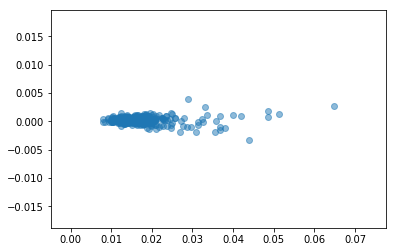

In [15]:
plt.scatter(std_l,rend_l, alpha=0.5)

In [18]:
sort_rend = np.argsort(rend_l)
sort_std = np.argsort(std_l)

#classement
classement = np.zeros_like(sort_rend)
for i in range(len(sort_rend)):
    classement[sort_rend[i]] += i*20
    classement[sort_std[len(sort_rend)-1-i]] += i

## 3) optimization (n=2) [a la main]

[220 141]
[0.02883616 0.01237531] [0.00400682 0.00145298]


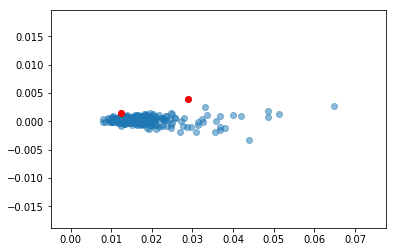

In [19]:
res = np.argsort(classement)[-2:]
print(res)
print(std_l[res],rend_l[res])

plt.scatter(std_l,rend_l, alpha=0.5)
plt.scatter(std_l[res],rend_l[res], c="red")

[220 141] [0.00400682 0.00145298]
rend: 0.00020613111853990025 & volatilité: 0.011402752345643793 -> poid: [0.61616162 0.38383838]


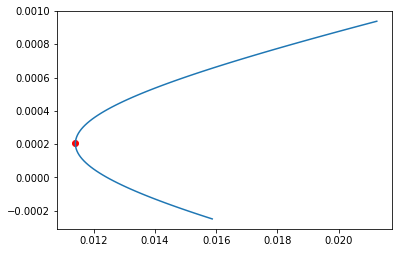

In [65]:
print(res,rend_l[res])

mat_return = np.array(l_return.values[res])
mat_return = np.nan_to_num(mat_return)

w = np.linspace(0, 1, num=100)
W = np.array([w, 1-w]).T

variance, std, rend = sharpe(W, mat_return)

minimum = np.argmin(std)
print(f"rend: {rend[minimum]} & volatilité: {std[minimum]} -> poid: {W[minimum]}")

plt.plot(std,rend)
plt.scatter(std[minimum], rend[minimum], c="red")

## Optimization (n=3) [a la main]

[ 71 220 141]


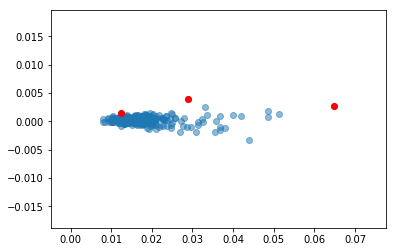

In [66]:
import itertools

w = np.linspace(0, 1, num=100)

n_w = np.array(list(itertools.permutations(w, 3)))

n_w = n_w[np.sum(n_w,axis=1) == 1]

res = np.argsort(classement)[-3:]
print(res)

plt.scatter(std_l,rend_l, alpha=0.5)
plt.scatter(std_l[res],rend_l[res], c="red")

In [67]:
mat_return = np.array(l_return.values[res])
mat_return = np.nan_to_num(mat_return)

variance, std, rend = sharpe(n_w, mat_return)

rend: -0.0018995958924977877 & volatilité: 0.00975561656633137 -> poid: [0.24242424 0.47474747 0.28282828]


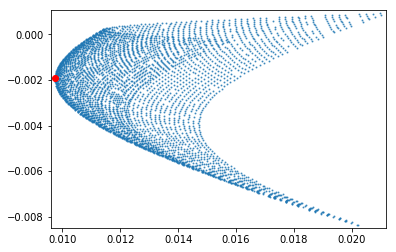

In [68]:
minimum = np.argmin(std)

print(f"rend: {rend[minimum]} & volatilité: {std[minimum]} -> poid: {n_w[minimum]}")

plt.margins(x=0, y=-0.01)
plt.scatter(std,rend,s=1, alpha=0.7)
plt.scatter(std[minimum], rend[minimum], c="red")

# Optimization (minimal var) [avec Resolution analytique]

> https://www.ephiquant.com/optimisation-de-portefeuille-modele-mean-variance-de-markowitz/

on cherche a optimiser le programme quadratique suivant

$$ 
 \left\{
    \begin{array}{ll}
       Min \ \sigma^2_p(w) = w^T\sigma w \\
       w^Tu = 1
    \end{array}
\right.$$

on va utiliser la méthode du multiplicateur de Lagrange:

$$
\mathcal{L}(\omega,\lambda) = \omega^\top \sigma \omega - \lambda(\omega^\top u-1)
$$

> où $\lambda$ est le multiplicateur de Lagrange

Nous allons ensuite calculer les dérivées partielles que nous allons spécifier égales à 0 : 

$$
\begin{cases} \frac{\partial\mathcal{L}}{\omega}= 2\sigma\omega-\lambda u=0 \quad \text{(a)}\\  \frac{\partial\mathcal{L}}{\partial\lambda}=\omega^\top u-1=0 \quad\quad\text{(b)}\end{cases}
$$

Nous allons d’abord tirer $\omega$ dans l’équation (a), après quoi nous allons le remplacer dans l’équation (b) par son expression: 

$$
\begin{split} \text{(a)} \quad 2\sigma\omega-\lambda u=0\quad  \implies \omega &= \frac{1}{2}\lambda\sigma^{-1}u \\ \text{(b)} \quad \omega^\top u-1=0 \implies \omega^\top u &= 1 \\ \frac{1}{2}\lambda u^\top\sigma^{-1}u &=1 \\  \lambda &= \frac{2}{u^\top\sigma^{-1}u} \end{split}
$$

Nous allons mettre cette dernière expression de $\lambda$ dans l’expression de $\omega$. Cela donnera ceci : 

$$
\begin{equation*}\omega=\frac{1}{2} \bigg(\frac{2}{u^{\top}\sigma^{-1}u} \bigg) \sigma^{-1}u \implies \omega=\frac{\sigma^{-1}u}{u^\top\sigma^{-1}u} \end{equation*}
$$

In [41]:
# u = [1, ..., 1]

In [69]:
res = np.argsort(classement)[-2:]
r = rend_l[res]
u = np.ones(r.shape[0])
mat_return = np.array(l_return.values[res])

sigma = np.cov(mat_return)

sigma_inv = np.linalg.inv(sigma) 

w = (sigma_inv @ u) / (u.T @ sigma_inv @ u)

w

array([0.61885575, 0.38114425])

rend: 0.00020613111853990025 & volatilité: 0.011402752345643793 -> poid: [0.61616162 0.38383838]
rend: 0.00020292883475365138 & volatilité: 0.011402485422442758 -> poid: [0.61885575 0.38114425]


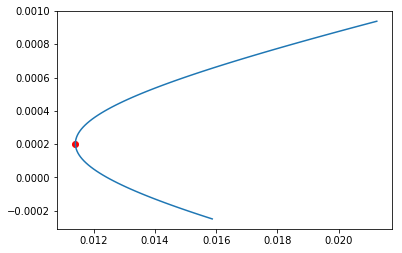

In [70]:
w_ = np.linspace(0, 1, num=100)
W = np.array([w_, 1-w_]).T


variance, std, rend = sharpe(W, mat_return)

minimum = np.argmin(std)

print(f"rend: {rend[minimum]} & volatilité: {std[minimum]} -> poid: {W[minimum]}")

plt.plot(std,rend)

variance, std, rend = sharpe(w, mat_return)

plt.scatter(std, rend, c="red")
print(f"rend: {rend} & volatilité: {std} -> poid: {w}")

## resolution analytique avec les 15 meilleurs actifs

In [71]:
res = np.argsort(classement)[-20:]
r = rend_l[res]
u = np.ones(r.shape[0])
mat_return = np.array(l_return.values[res])

sigma = np.cov(mat_return)

sigma_inv = np.linalg.inv(sigma) 

w = (sigma_inv @ u) / (u.T @ sigma_inv @ u)

w

array([0.05245864, 0.01814418, 0.05647379, 0.01448177, 0.04989855,
       0.05755854, 0.09460189, 0.04684481, 0.02812832, 0.04690751,
       0.04815918, 0.01614631, 0.03179051, 0.07287882, 0.01178292,
       0.09387525, 0.07773192, 0.0457005 , 0.07544664, 0.06098996])

In [72]:
variance, std, rend = sharpe(w, mat_return)
print(f"rend: {rend} & volatilité: {std} -> poid: {w}")

rend: 0.0001302941859898724 & volatilité: 0.0038144386258752794 -> poid: [0.05245864 0.01814418 0.05647379 0.01448177 0.04989855 0.05755854
 0.09460189 0.04684481 0.02812832 0.04690751 0.04815918 0.01614631
 0.03179051 0.07287882 0.01178292 0.09387525 0.07773192 0.0457005
 0.07544664 0.06098996]


## Benchmark

Regardons l'influence du nombre d'actif sur le rendement et la volatilité.

[2] rend: 0.00020292883475365138 & volatilité: 0.011402485422442758
[3] rend: -0.0019448059996929816 & volatilité: 0.009754697924288444
[4] rend: -0.001126594882188054 & volatilité: 0.009002648946899429
[5] rend: -0.00023061812917280468 & volatilité: 0.00726938666483132
[6] rend: -0.00017489068448011072 & volatilité: 0.006945697594856889
[7] rend: -0.0003123793679231925 & volatilité: 0.006230918592133479
[8] rend: -0.0001826053190139358 & volatilité: 0.005835715979880343
[9] rend: -0.00011063657376837849 & volatilité: 0.005794499718427533
[10] rend: -0.00013468767867757148 & volatilité: 0.005563377978967319
[11] rend: -0.0005700015586450462 & volatilité: 0.005220362136215341
[12] rend: -0.0005422301156435292 & volatilité: 0.005063401239422215
[13] rend: -0.00042009654200917963 & volatilité: 0.0048043268227475
[14] rend: -4.793018088142866e-05 & volatilité: 0.004460071882926841
[15] rend: -4.891381425877424e-05 & volatilité: 0.004333835054555039
[16] rend: 8.557548956196167e-06 & volati

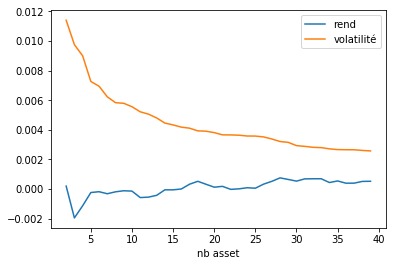

In [73]:
hist = []
for i in range(2,40,1):
    res = np.argsort(classement)[-i:]
    r = rend_l[res]
    u = np.ones(r.shape[0])
    mat_return = np.array(l_return.values[res])

    sigma = np.cov(mat_return)
    sigma_inv = np.linalg.inv(sigma) 

    w = (sigma_inv @ u) / (u.T @ sigma_inv @ u)
    variance, std, rend = sharpe(w, mat_return)
    print(f"[{i}] rend: {rend} & volatilité: {std}")
    hist.append([rend, std])

hist = np.array(hist)

plt.plot(range(2,40,1),hist[:,0], label="rend")
plt.plot(range(2,40,1),hist[:,1], label="volatilité")
plt.xlabel("nb asset")
plt.legend()

## Optimisation

In [74]:
res = np.argsort(classement)[-2:]
r = rend_l[res]
u = np.ones(r.shape[0])
mat_return = np.array(l_return.values[res])

sigma = np.cov(mat_return)
sigma_inv = np.linalg.inv(sigma) 

$$
\begin{equation*}\omega=E\mu_0+F\end{equation*}
$$

avec:

$$
E=\frac{1}{D}\sigma^{-1}(C\mu-Au)\quad \text{et} \quad F=\frac{1}{D}\sigma^{-1}(-A\mu+Bu)
$$


Nous allons définir 
- $A=u^\top\sigma^{-1}\mu=\mu^\top\sigma^{-1}u$ 
- $B=\mu^\top\sigma^{-1}\mu$ 
- $C=u^\top\sigma^{-1}u$
- $D=BC-A^2$

In [75]:
A = u.T @ sigma_inv @ r 
B = r.T @ sigma_inv @ r
C = u.T @ sigma_inv @ u
D = B*C - (A**2)

In [79]:
E = (1/D) * sigma_inv @ (C*r - A*u)
F = (1/D) * sigma_inv @ (-A*r + B*u)

w = E* 0.004 + F
w

array([0.99733108, 0.00266892])

In [80]:
variance, std, rend = sharpe(w, mat_return)
print(f"[{i}] rend: {rend} & volatilité: {std}")

[0.0195] rend: -0.0002469314630822446 & volatilité: 0.015816070905437025


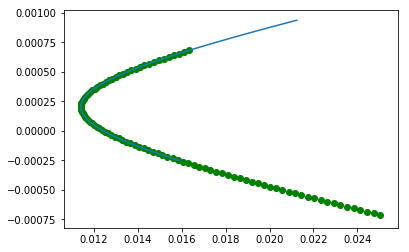

In [84]:
w_ = np.linspace(0, 1, num=100)
W = np.array([w_, 1-w_]).T


variance, std, rend = sharpe(W, mat_return)

minimum = np.argmin(std)
plt.plot(std,rend)

target_ = np.linspace(0.002, 0.005, num=100)
best = ""

for i in target_:
    w = E* i + F
    variance, std, rend = sharpe(w, mat_return)
    if std < rend:
        best = f"rend: {rend} & volatilité: {std}"
        plt.scatter(std, rend, c="red")
    else:
        plt.scatter(std, rend, c="green")
        
print(best)

En Rouge: rendement > risque  
En Vert : rendement < risque

## N=40

In [85]:
res = np.argsort(classement)[-10:]
mat_return = np.array(l_return.values[res])

In [86]:
def get_w(mat_return, u_t= 0.0017):
    r = mat_return.mean(axis=1)
    u = np.ones(r.shape[0])
    
    sigma = np.cov(mat_return)
    sigma_inv = np.linalg.inv(sigma) 
    
    A = u.T @ sigma_inv @ r 
    B = r.T @ sigma_inv @ r
    C = u.T @ sigma_inv @ u
    D = B*C - (A**2)
    
    E = (1/D) * sigma_inv @ (C*r - A*u)
    F = (1/D) * sigma_inv @ (-A*r + B*u)

    w = E* u_t + F
    return w


w_20 = get_w(mat_return, 0.003)
w_20

array([ 0.03097011,  0.3588573 ,  0.319068  , -0.07577252,  0.12146868,
        0.62903823,  0.70965119, -1.2690067 ,  0.02101658,  0.15470913])

rend: 0.019499999999999997 & volatilité: 0.011637823096487889


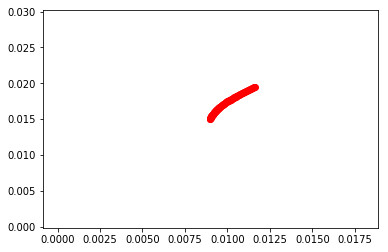

In [36]:
target_ = np.linspace(0.015, 0.0195, num=100)
best = ""

for i in target_:
    w = get_w(mat_return, i)
    if all(element < 0  for element in w):
        break
    variance, std, rend = sharpe(w, mat_return)
    if std < rend:
        best = f"rend: {rend} & volatilité: {std}"
        plt.scatter(std, rend, c="red")
    else:
        plt.scatter(std, rend, c="green")
        
print(best)

In [20]:
l_id[res]

array(['2024', '1958'], dtype='<U4')

## Find %NAV

In [33]:
new_portfolio = {
    "label":"EPITA_PTF_8",
    "currency": {
        "code":"EUR"
    },
    "type":"front",
    "values": {
        "2016-06-01": [
            {
            "asset": {
                "asset": 2024,
                "quantity": 2
                }
            }
        ]
    }
}

In [34]:
req.push(new_portfolio)

In [35]:
portfolio = req.get_portfolio()
portfolio

'{"label":"EPITA_PTF_8","currency":{"code":"EUR"},"type":"front","values":{}}'